In [23]:
import pandas
import numpy
import random
import sys

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding
from keras.layers import LSTM, GRU, Dropout
from keras.optimizers import RMSprop, Adam, SGD

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
cd ..

/Users/mmccurdy/code/starwars-namer


In [3]:
from swnamer.process import *

In [4]:
names = pandas.read_csv('output/names.csv')

In [5]:
names.sample(5)

,name
7920,^^^robert$$$
4723,^^^rivi$$$
1688,^^^corrie$$$
7477,^^^shara$$$
5477,^^^avis$$$


In [6]:
starwars_names = pandas.read_csv('output/starwars_processed.csv')

In [7]:
starwars_names.sample(5)

,name
699,^^^ewok$$$
691,^^^gamorrean guards$$$
410,^^^dexter jettster$$$
692,^^^yuzzum$$$
265,^^^cassian andor$$$


In [8]:
timesteps = 3

In [9]:
combined = pandas.concat((names, starwars_names), axis=0)

In [10]:
token_to_index, index_to_token = create_indices(combined, 'name')

In [11]:
chars = token_to_index.keys()

In [12]:
chars

dict_keys(['^', 'l', 'a', 'u', 'r', 'i', 'n', 'e', '$', 'b', 't', 's', 'd', 'o', 'c', 'm', 'p', 'g', 'k', 'y', 'j', 'v', 'h', '-', 'w', 'f', 'q', 'x', 'z', ' ', "'", '8', '4', '3', '9', '1', '5', '/', '2', '0', 'é', '.', '7', 'î', '"', '6', 'á', '\n'])

In [13]:
vocab_size = len(chars)
vocab_size

48

In [14]:
chunks, next_char = chunk_names(names, 'name', timesteps)

In [15]:
X, y = create_training_vectors(chunks, next_char, token_to_index, timesteps, vocab_size)

In [28]:
model = Sequential()
model.add(LSTM(64, input_shape=(timesteps, vocab_size), return_sequences=True))
model.add(LSTM(64, input_shape=(timesteps, vocab_size), return_sequences=False))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
optimizer = SGD(lr=.01, momentum=.99, nesterov=True)
model.compile(optimizer, 'categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 3, 64)             28928     
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 48)                3120      
_________________________________________________________________
activation_2 (Activation)    (None, 48)                0         
Total params: 65,072
Trainable params: 65,072
Non-trainable params: 0
_________________________________________________________________


In [29]:
sampler = SampleNames(chunks, timesteps, vocab_size, token_to_index, index_to_token)
earlystopping = EarlyStopping(mode='min', patience=7, min_delta=.001)
checkpoint = ModelCheckpoint('output/names.{epoch:02d}-{val_loss:.2f}.hdf5', save_best_only=True)
callbacks = [sampler, earlystopping, checkpoint]

In [30]:
history = model.fit(X, y, epochs=100, batch_size=32, validation_split=.2, callbacks=callbacks)

Train on 63744 samples, validate on 15937 samples
Epoch 1/100
63744/63744 [==============================] - 13s 203us/step - loss: 1.9677 - val_loss: 1.7414

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "^^^"
^^^carie$$$
----- diversity: 0.5
----- Generating with seed: "^^^"
^^^cin$$$
----- diversity: 1.0
----- Generating with seed: "^^^"
^^^bviedas$$$
----- diversity: 1.2
----- Generating with seed: "^^^"
^^^fi4seohunshlayl$$$
Epoch 2/100
63744/63744 [==============================] - 12s 191us/step - loss: 1.6846 - val_loss: 1.6489
Epoch 3/100
63744/63744 [==============================] - 12s 189us/step - loss: 1.6184 - val_loss: 1.6070
Epoch 4/100
63744/63744 [==============================] - 12s 195us/step - loss: 1.5804 - val_loss: 1.5833
Epoch 5/100
63744/63744 [==============================] - 12s 194us/step - loss: 1.5510 - val_loss: 1.5626
Epoch 6/100
63744/63744 [==============================] - 12s 189us/step - loss: 1.5231 - val

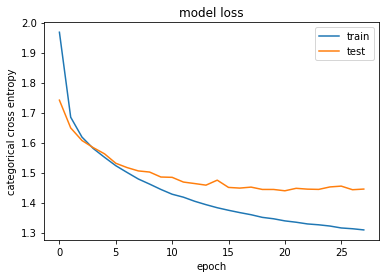

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [33]:
model = Sequential()
model.add(LSTM(80, input_shape=(timesteps, vocab_size), return_sequences=True))
model.add(Dropout(.25))
model.add(LSTM(80, input_shape=(timesteps, vocab_size), return_sequences=False))
model.add(Dropout(.25))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))
optimizer = SGD(lr=.01, momentum=.99, nesterov=True, clipvalue=1)
model.compile(optimizer, 'categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 80)             41280     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 80)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 48)                3888      
_________________________________________________________________
activation_4 (Activation)    (None, 48)                0         
Total params: 96,688
Trainable params: 96,688
Non-trainable params: 0
_________________________________________________________________


In [34]:
sampler = SampleNames(chunks, timesteps, vocab_size, token_to_index, index_to_token)
earlystopping = EarlyStopping(mode='min', patience=7, min_delta=.001)
checkpoint = ModelCheckpoint('output/names.{epoch:02d}-{val_loss:.2f}.hdf5')
callbacks = [sampler, earlystopping, checkpoint]

In [35]:
history = model.fit(X, y, epochs=100, batch_size=64, validation_split=.2, callbacks=callbacks)

Train on 63744 samples, validate on 15937 samples
Epoch 1/100
63744/63744 [==============================] - 10s 162us/step - loss: 2.1291 - val_loss: 1.8797

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "bir"
bire$$$
----- diversity: 0.5
----- Generating with seed: "bir"
birn$$$
----- diversity: 1.0
----- Generating with seed: "bir"
biryl$$$
----- diversity: 1.2
----- Generating with seed: "bir"
bire$$$
Epoch 2/100
63744/63744 [==============================] - 8s 133us/step - loss: 1.8249 - val_loss: 1.7510
Epoch 3/100
63744/63744 [==============================] - 9s 141us/step - loss: 1.7296 - val_loss: 1.6859
Epoch 4/100
63744/63744 [==============================] - 9s 144us/step - loss: 1.6885 - val_loss: 1.6669
Epoch 5/100
63744/63744 [==============================] - 9s 139us/step - loss: 1.6575 - val_loss: 1.6295
Epoch 6/100
63744/63744 [==============================] - 9s 137us/step - loss: 1.6297 - val_loss: 1.6023
Epoch 7/100
6374

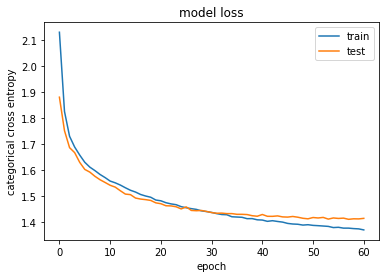

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [63]:
min_index = numpy.argmin(history.history['val_loss'])
min_index, history.history['val_loss'][min_index]

(57, 1.41070447684217)

In [64]:
model = load_model('output/names.40-1.42.hdf5')

In [65]:
model.layers

In [66]:
gen = NameGenerator(timesteps, vocab_size, token_to_index, index_to_token, model)

In [72]:
gen.generate(seed='^^^')

['freen', 'andalareen', 'sebani', 'jane', 'stee']

## Freeze first two layers

In [73]:
for layer in model.layers[:2]:
    layer.trainable = False

In [74]:
optimizer = SGD(lr=.01, momentum=.99, nesterov=True)
model.compile(optimizer, 'categorical_crossentropy')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 3, 80)             41280     
_________________________________________________________________
dropout_3 (Dropout)          (None, 3, 80)             0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 48)                3888      
_________________________________________________________________
activation_4 (Activation)    (None, 48)                0         
Total params: 96,688
Trainable params: 55,408
Non-trainable params: 41,280
_________________________________________________________________


In [75]:
starwars_chunks, starwars_next_char = chunk_names(starwars_names, 'name', timesteps)

In [76]:
X_sw, y_sw = create_training_vectors(starwars_chunks, starwars_next_char, token_to_index, timesteps, vocab_size)

In [77]:
sampler = SampleNames(starwars_chunks, timesteps, vocab_size, token_to_index, index_to_token)
earlystopping = EarlyStopping(mode='min', patience=10, min_delta=.001)
checkpoint = ModelCheckpoint('output/starwars-transfer.{epoch:02d}-{val_loss:.2f}.hdf5')
callbacks = [sampler, earlystopping, checkpoint]

In [78]:
history = model.fit(X_sw, y_sw, epochs=100, batch_size=32, validation_split=.1, callbacks=callbacks)

Train on 10233 samples, validate on 1137 samples
Epoch 1/100
10233/10233 [==============================] - 3s 336us/step - loss: 2.4759 - val_loss: 2.2370

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "^ew"
^ewandanan alana$$$
----- diversity: 0.5
----- Generating with seed: "^ew"
^ewell$$$
----- diversity: 1.0
----- Generating with seed: "^ew"
^ewdudcarhydetmlaeslomei tonggana-spenrowlinedo lan k
----- diversity: 1.2
----- Generating with seed: "^ew"
^ewinyranlentirfabmoxrarineshtynwhuk$$$
Epoch 2/100
10233/10233 [==============================] - 2s 182us/step - loss: 2.1972 - val_loss: 2.1722
Epoch 3/100
10233/10233 [==============================] - 2s 193us/step - loss: 2.1354 - val_loss: 2.1421
Epoch 4/100
10233/10233 [==============================] - 2s 207us/step - loss: 2.0969 - val_loss: 2.1141
Epoch 5/100
10233/10233 [==============================] - 2s 175us/step - loss: 2.0557 - val_loss: 2.0997
Epoch 6/100
10233/10233 [=========

In [79]:
history = _78

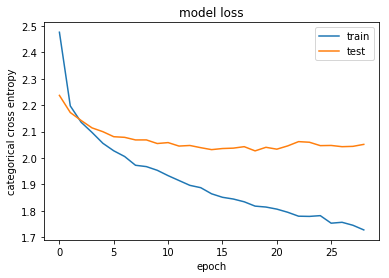

In [80]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### Looks like overfitting

In [88]:
model = load_model('output/names.40-1.42.hdf5')

In [89]:
# Freeze LSTM layers
model.layers[0].trainable = False
model.layers[2].trainable = False

In [90]:
optimizer = SGD(lr=.01, momentum=.99, nesterov=True, clipvalue=1)
model.compile(optimizer, 'categorical_crossentropy')

In [91]:
sampler = SampleNames(starwars_chunks, timesteps, vocab_size, token_to_index, index_to_token)
earlystopping = EarlyStopping(mode='min', patience=10, min_delta=.001)
checkpoint = ModelCheckpoint('output/starwars-transfer.{epoch:02d}-{val_loss:.2f}.hdf5')
callbacks = [sampler, earlystopping, checkpoint]

In [92]:
history = model.fit(X_sw, y_sw, epochs=100, batch_size=32, validation_split=.1, callbacks=callbacks)

Train on 10233 samples, validate on 1137 samples
Epoch 1/100
10233/10233 [==============================] - 3s 271us/step - loss: 2.5919 - val_loss: 2.3351

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "$$$"
$$$
----- diversity: 0.5
----- Generating with seed: "$$$"
$$$
----- diversity: 1.0
----- Generating with seed: "$$$"
$$$
----- diversity: 1.2
----- Generating with seed: "$$$"
$$$
Epoch 2/100
10233/10233 [==============================] - 1s 108us/step - loss: 2.2966 - val_loss: 2.2518
Epoch 3/100
10233/10233 [==============================] - 1s 107us/step - loss: 2.2445 - val_loss: 2.2291
Epoch 4/100
10233/10233 [==============================] - 1s 103us/step - loss: 2.2192 - val_loss: 2.2143
Epoch 5/100
10233/10233 [==============================] - 1s 110us/step - loss: 2.2021 - val_loss: 2.2053
Epoch 6/100
10233/10233 [==============================] - 1s 102us/step - loss: 2.1873 - val_loss: 2.2000
Epoch 7/100
10233/10233 [==========

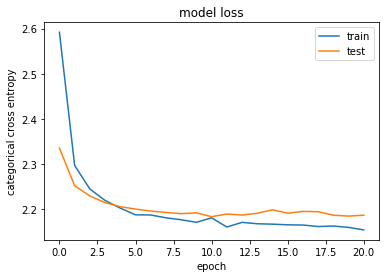

In [93]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('categorical cross entropy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [98]:
numpy.argmin(history.history['val_loss'])

10

In [99]:
model = load_model('output/starwars-transfer.10-2.05.hdf5')

In [100]:
gen = NameGenerator(timesteps, vocab_size, token_to_index, index_to_token, model)

In [108]:
gen.generate(n=50, diversity=.85)

['sin darth mara',
 'sar',
 'apus',
 "dart' argorrio",
 'éurus hick',
 'sarete giel',
 'darth ple ',
 'cel',
 'rion stel cellarikandastor brugbe',
 'rick',
 'tas ',
 'grea tramontgranssell',
 'witt ',
 'jar2kaakna a',
 'dan fendi hutt ',
 'chur',
 'tal ort',
 'reydosi',
 'jar jarek ban',
 'udsan paxangana',
 'hora ballessst',
 'oord',
 'cammerebon',
 'cattody',
 'rujass',
 'hamnalfo farlel',
 'quer zollessumd',
 'railon instarahdorth slydes',
 'darth bl',
 'jean ol torjerer kes',
 '0alem',
 'orriestskywald',
 'cappier ver e ger',
 'osram',
 'silitrese',
 'deor  kin',
 'hen or',
 'rom',
 'ter',
 'miat ewren',
 'dins',
 'marek',
 'vickorrie',
 'javang deral togdan atian karek',
 'sastli reeka ',
 'bing alkoral solon',
 'sybill',
 'rutt e lural zhirus',
 'darth bino erson',
 'petda thektarea than anu']

In [ ]:
model.save()